<a href="https://colab.research.google.com/github/Saumye13/Surgical-Tool-Segmentation/blob/main/Surgical_Tool_Sementation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all the necessary Modules and path variable



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import sklearn as sk
import json
%matplotlib inline

In [ ]:
import os
import segmentation_models as sm
import cv2

Segmentation Models: using `keras` framework.


In [ ]:
path = "D:\Hackathon\TensorFlow_env\PS3 Train\PS3 Train"
b = ['seq_1','seq_2','seq_3','seq_4','seq_5','seq_6','seq_7','seq_9','seq_10','seq_11','seq_12','seq_13','seq_14','seq_15','seq_16']
b = [path + "\\" + i for i in b]
print(b)

['D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_1', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_2', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_3', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_4', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_5', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_6', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_7', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_9', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_10', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_11', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_12', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_13', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_14', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_15', 'D:\\Hackathon\\TensorFlow_env\\PS3 Train\\PS3 Train\\seq_16']


In [ ]:
se=[]
fr=[]
for k in b:
  for i in os.listdir(k):
    if(i==".DS_Store"):
      pass
    else:
      for j in os.listdir(k+"\\"+i):
        if(i=="frames"):
          fr.append(k+"\\"+i+"\\"+j)
        elif(i=="labels"):
          se.append(k+"\\"+i+"\\"+j)


In [ ]:
print(se[0])

D:\Hackathon\TensorFlow_env\PS3 Train\PS3 Train\seq_1\labels\frame000.png


In [ ]:
# X is the list of paths to all the frames
# y is the list of paths to all the masks
X = fr
y = se

In [ ]:
print(X[1000],y[1000])

D:\Hackathon\TensorFlow_env\PS3 Train\PS3 Train\seq_7\frames\frame106.png D:\Hackathon\TensorFlow_env\PS3 Train\PS3 Train\seq_7\labels\frame106.png


# Preprocessing

In [ ]:
from matplotlib.pyplot import imread
image=imread(X[0])
print(image.shape)

(1024, 1280, 3)


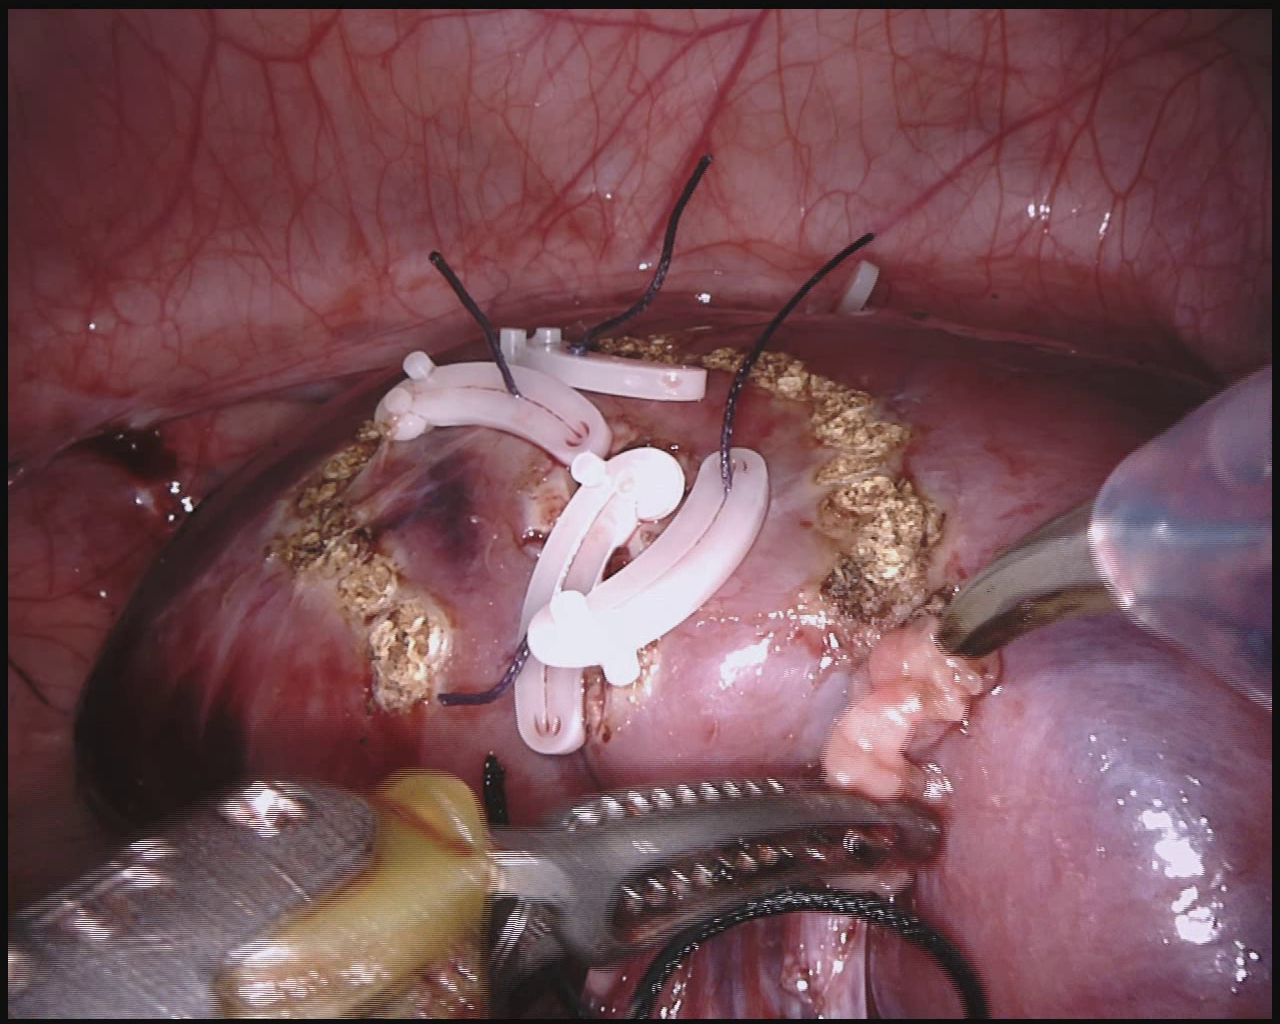

In [ ]:
from IPython.display import Image
Image(X[100])

In [ ]:
from matplotlib.pyplot import imread
image=imread(X[0])
print(image.shape)

(1024, 1280, 3)


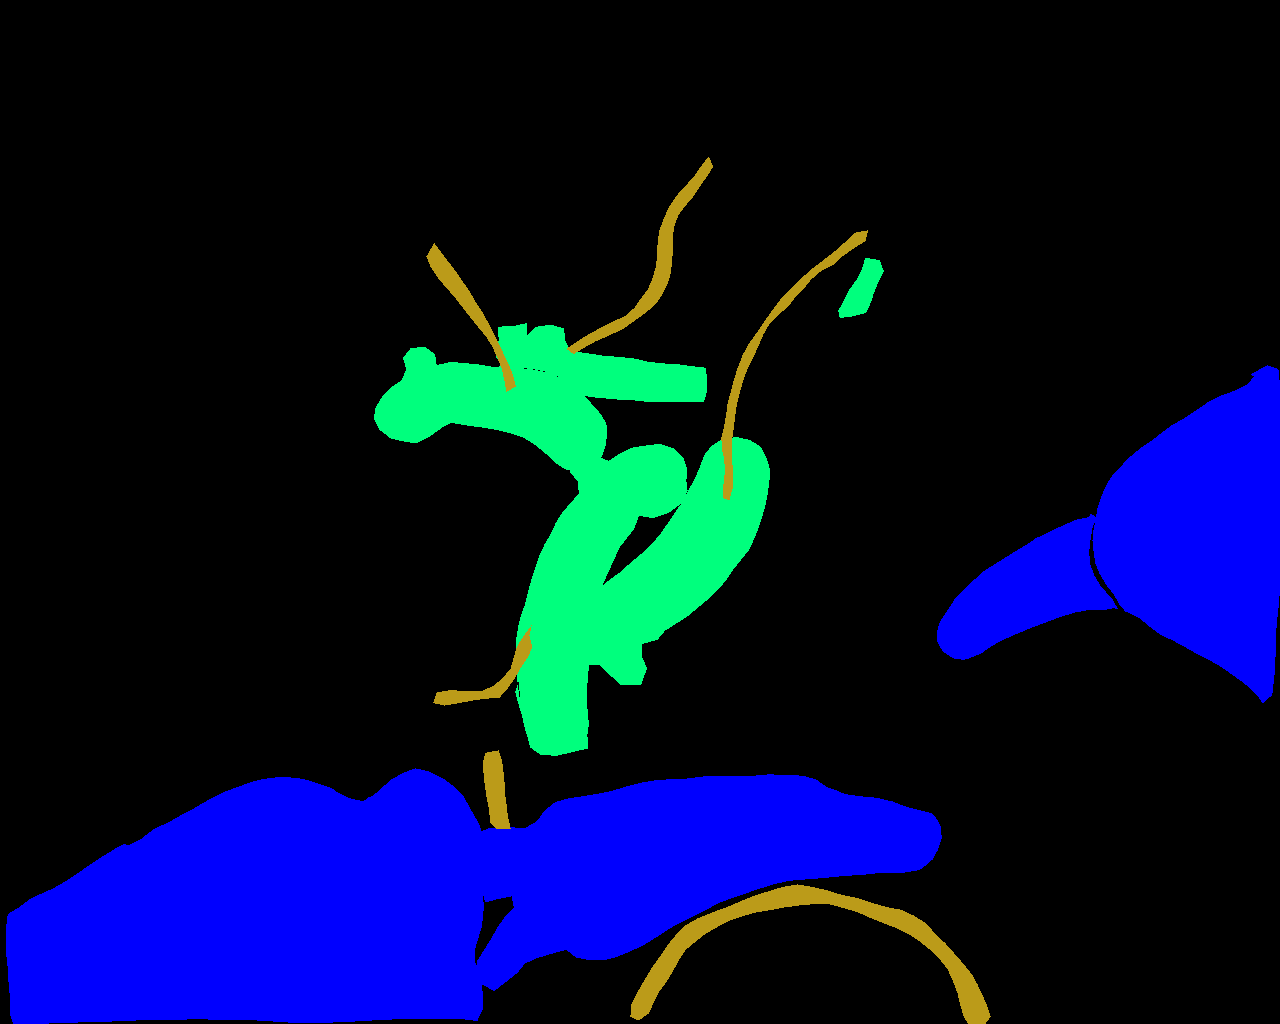

In [ ]:
from IPython.display import Image
Image(y[100])

In [ ]:
from sklearn.model_selection import train_test_split
#splitting the data into train and validation

X_train,X_val,y_train,y_val = X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)
NUM_IMAGES = len(X_train)
NUM_IMAGES

1788

In [ ]:
IMG_SIZE = 224

#Function to preprocess images
def preprocess_image(image_path):
  ''' Takes image path as input and turns image to a tensor and returns the obtained tensor '''

  #Read image file
  image=tf.io.read_file(image_path)

  #Turn the image into numeric tensor with 3 color channels
  image=tf.image.decode_jpeg(image,channels=3)

  #Converting color channel values from 0-255 to 0-1
  image=tf.image.convert_image_dtype(image,tf.float32)

  #Resize the image to 224 224
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

In [ ]:
IMG_SIZE = 224

#Function to preprocess images
def preprocess_mask(image_path):
  ''' Takes image path as input and turns image to a tensor and returns the obtained tensor '''

  #Read image file
  image=tf.io.read_file(image_path)

  #Turn the image into numeric tensor with 3 color channels
  image=tf.image.decode_jpeg(image,channels=3)

  #Converting color channel values from 0-255 to 0-1
  image=tf.image.convert_image_dtype(image,tf.float32)

  #Resize the image to 224 224
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  image = tf.cast(image, tf.float32)

  return image

In [ ]:
def get_image_label(image_path,mask):
  image=preprocess_image(image_path)
  mask=preprocess_mask(mask)
  return image,mask


In [ ]:
#Defining the Batch size
BATCH_SIZE = 4
#Creating a function to turn the data into batches

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  '''
  This function creates batches of data from images(X) and labels(y).
  If the data is training data , the function will return the data after shuffling.
  If it is validation data no shuffling will be done.
  It does not need to accept labels in case it is test data.

  '''
  #Case 1 if test data is passed
  if test_data:
    print("Creating test batches...")
    #Create a tensor object using tf.constant and then creating a tensor dataset using Dataset.from_tensor_slices
    data=tf.data.Dataset.from_tensor_slices(tf.constant(X))

    #Applies the preprocess function across the batches creatied by batch() method using map() method
    data_batch=data.map(preprocess_image).batch(batch_size)

    #Return the data batch
    return data_batch

  elif valid_data:
    print("Creating validation batches...")
    #Create a tensor object using tf.constant and then creating a tensor dataset using Dataset.from_tensor_slices
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))

    #Applies the get_image_label function across the batches creatied by batch() method using map() method
    data_batch=data.map(get_image_label).batch(batch_size)

    #Return the data batch
    return data_batch

  else:
    print("Creating training batches...")
    #Create a tensor object using tf.constant and then creating a tensor dataset using Dataset.from_tensor_slices
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))

    #Applies the get_image_label function across the batches creatied by batch() method using map() method
    data_batch=data.map(get_image_label).batch(batch_size)

    #Return the data batch
    return data_batch


In [ ]:
train_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val,valid_data=True)

Creating training batches...
Creating validation batches...


In [ ]:
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)))

In [ ]:
train_images,train_labels=next(train_data.as_numpy_iterator())
val_images,val_labels=next(val_data.as_numpy_iterator())

# Training the Model

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.keras.layers.PReLU(), input_shape=(224,224,3), padding='same'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.keras.layers.PReLU(), padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout)
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same'))
model.compile(optimizer='adam',
              loss=sm.losses.binary_focal_loss,
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       sm.metrics.IOUScore(threshold=0.5),
                       sm.metrics.FScore(threshold=0.5)])

In [ ]:
import torch
from torch import nn

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel2 = nn.ReLU()
    self.mpool = nn.MaxPool2d(kernel_size=2)
    self.conv3 = nn.Conv2d(64,64,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel3 = nn.ReLU()
    self.conv4 = nn.Conv2d(64,64,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel4 = nn.ReLU()
    self.mpool2 = nn.MaxPool2d(kernel_size=2)
    self.conv5 = nn.Conv2d(64,64,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel5 = nn.ReLU()
    self.conv6 = nn.Conv2d(64,64,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel6 = nn.ReLU()
    self.upsam = nn.UpsamplingNearest2d(scale_factor=2)
    self.conv7 = nn.Conv2d(64,64,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel7 = nn.ReLU()
    self.conv8 = nn.Conv2d(64,32,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel8 = nn.ReLU()
    self.upsam2 = nn.UpsamplingNearest2d(scale_factor=2)
    self.conv9 = nn.Conv2d(32,3,kernel_size=3,padding=1,padding_mode="reflect")
    self.rel9 = nn.ReLU()
  def forward(self,x):
    x = self.conv1(x)
    x = self.rel1(x)
    x = self.conv2(x)
    x = self.rel2(x)
    x = self.mpool(x)
    x = self.conv3(x)
    x = self.rel3(x)
    x = self.conv4(x)
    x = self.rel4(x)
    x = self.mpool2(x)
    x = self.conv5(x)
    x = self.rel5(x)
    x = self.conv6(x)
    x = self.rel6(x)
    x = self.upsam(x)
    x = self.conv7(x)
    x = self.rel7(x)
    x = self.conv8(x)
    x = self.rel8(x)
    x = self.upsam2(x)
    x = self.conv9(x)
    x = self.rel9(x)
    return x
model = Generator()

In [ ]:
from torchsummary import summary

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity,peak_signal_noise_ratio
from PIL import Image

In [ ]:
x = Image.open("/content/sharp0.jpg")
y = Image.open("/content/val_deblurred6.jpg")

In [ ]:
z_ = np.array(x)
z_1 = np.array(y)

In [ ]:
print(structural_similarity(z_,z_1,channel_axis=2))

0.8133068151928011


In [ ]:
print(peak_signal_noise_ratio(z_1,z_))

27.565735377080514


In [ ]:
summary(model, input_size = (3, 1024, 1024), batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [1, 32, 1024, 1024]             896
              ReLU-2        [1, 32, 1024, 1024]               0
            Conv2d-3        [1, 64, 1024, 1024]          18,496
              ReLU-4        [1, 64, 1024, 1024]               0
         MaxPool2d-5          [1, 64, 512, 512]               0
            Conv2d-6          [1, 64, 512, 512]          36,928
              ReLU-7          [1, 64, 512, 512]               0
            Conv2d-8          [1, 64, 512, 512]          36,928
              ReLU-9          [1, 64, 512, 512]               0
        MaxPool2d-10          [1, 64, 256, 256]               0
           Conv2d-11          [1, 64, 256, 256]          36,928
             ReLU-12          [1, 64, 256, 256]               0
           Conv2d-13          [1, 64, 256, 256]          36,928
             ReLU-14          [1, 64, 2

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime
import os
#Create a function to build a tensorboard callback
def create_tensorboard_callback():
  logdir=os.path.join("./Plant Village",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=70)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.00000001
)

In [ ]:
NUM_EPOCHS=20

In [ ]:
tensorboard=create_tensorboard_callback()
model.fit(x=train_data,
          epochs=NUM_EPOCHS,
          validation_data=val_data,
          validation_freq=1,
          callbacks=[tensorboard,early_stopping,lr_callback]
          )

Epoch 1/20
447/447 [==============================] - 63s 131ms/step - loss: 0.0156 - binary_accuracy: 0.9365 - iou_score: 0.1493 - f1-score: 0.1638 - val_loss: 0.0108 - val_binary_accuracy: 0.9373 - val_iou_score: 0.1564 - val_f1-score: 0.1635 - lr: 0.0010
Epoch 2/20
447/447 [==============================] - 60s 134ms/step - loss: 0.0097 - binary_accuracy: 0.9535 - iou_score: 0.2398 - f1-score: 0.2888 - val_loss: 0.0095 - val_binary_accuracy: 0.9521 - val_iou_score: 0.2510 - val_f1-score: 0.3018 - lr: 0.0010
Epoch 3/20
447/447 [==============================] - 58s 130ms/step - loss: 0.0077 - binary_accuracy: 0.9627 - iou_score: 0.3057 - f1-score: 0.3545 - val_loss: 0.0066 - val_binary_accuracy: 0.9686 - val_iou_score: 0.3564 - val_f1-score: 0.4023 - lr: 0.0010
Epoch 4/20
447/447 [==============================] - 59s 131ms/step - loss: 0.0072 - binary_accuracy: 0.9651 - iou_score: 0.3160 - f1-score: 0.3631 - val_loss: 0.0069 - val_binary_accuracy: 0.9702 - val_iou_score: 0.3696 - va

KeyboardInterrupt: 

In [ ]:
!nvidia-smi

Fri Apr 12 22:58:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0             N/A / ERR!  |    3996MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_333 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 conv2d_334 (Conv2D)         (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_335 (Conv2D)         (None, 112, 112, 32)      9248      
                                                                 
 conv2d_336 (Conv2D)         (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                

In [ ]:
def save_model(model,suffix=None):
  modeldir=os.path.join("./models",datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  model_path=modeldir+'-'+suffix+'.tf'
  print(f"Saving model to {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
save_model(model,suffix="Simple_CNN_Segmentation")

Saving model to ./models\20240412-233519-Simple_CNN_Segmentation.tf...


INFO:tensorflow:Assets written to: ./models\20240412-233519-Simple_CNN_Segmentation.tf\assets


INFO:tensorflow:Assets written to: ./models\20240412-233519-Simple_CNN_Segmentation.tf\assets


'./models\\20240412-233519-Simple_CNN_Segmentation.tf'

# Testing

In [ ]:
#Loading the model
m = tf.keras.models.load_model("20240413-060137-Simple_CNN_Segmentation_Iter3.tf",
                         custom_objects = {"binary_crossentropy_plus_jaccard_loss": loss,"acc":acc,"iou_score":iou,"f1-score":f1})

In [ ]:
path = "D:\Assignments\AI\ML\drive-download-20240413T044321Z-001"
b = ['seq_1','seq_2','seq_3','seq_4']
b = [path + "\\" + i +"\\" + "frames" for i in b]
print(b)

In [ ]:
import os
l = []
for i in b:
  k=[]
  for j in os.listdir(i):
    k.append(i+"\\"+j)
  l.append(k)
print(l[0][0])

In [ ]:
# Getting the seperate video sequences
print(len(l))
p,q,r,s =l[0],l[1],l[2],l[3]

In [ ]:
#converting video sequence into tensor test dataset
test_data1=create_data_batches(p,test_data=True)
test_data1.element_spec

In [ ]:
a = m1.predict(test_data1)

In [ ]:
plt.imshow(a[75])

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir="D:\\Hackathon\\TensorFlow_env\\logs"